In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


from pathlib import Path

import numpy as np
import openmm
import Find_D.tools.simulator as simulator
from openff.toolkit import topology
from openff.units import unit
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import linregress
from tqdm import tqdm

In [77]:
import openmm

In [2]:
box =Find_D.boxer.Box.load('boxes/box_ocm_44_1530.json')Find_D.boxer

In [4]:
box.parametrize()

In [5]:
simulation, reporter = simulator.create_simulation(
        box=box,
        T=25,
        boxes_path=Path('.'),
    )

Equilibration: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


In [65]:
system = box.box_parametrized.to_openmm_system()

In [75]:
top = openmm.app.PDBFile('results/box_dmag_22_1050/box_dmag_22_1050.pdb')

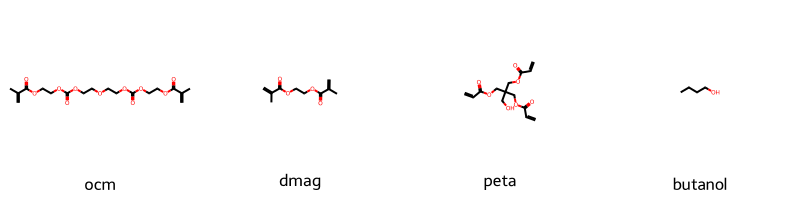

In [7]:
Draw.MolsToGridImage(
    Find_D.tools.base.RD_MOLECULES.values(),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in Find_D.tools.base.RD_MOLECULES.keys(Find_D.tools.base

# Box creation

# Simulation

In [ ]:
from tqdm import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [ ]:
check_freq=100
simulation, msdReporter = funcs.create_simulation(b, dt=1,check_freq = check_freq)

product_cycle = tqdm(iterable=range(100))
product_cycle.set_description_str('Product')
for i in product_cycle:
    simulation.step(check_freq)

In [ ]:
box = funcs.Box.load("boxes/box_dmag_22_1050.json")
box.parametrize()
box.minimaze()

In [ ]:
simulation,reporter = funcs.create_simulation(box)

In [ ]:
product_cycle = tqdm(iterable=range(100))
product_cycle.set_description_str('Product')
for i in product_cycle:
    simulation.step(100)

# Describe reporter

In [1]:
from tqdm import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [ ]:
df = reporter.df

for mol_type in list(df.columns)[1:]:
    linear_model = linregress(df['Time'], df[mol_type])
    slope = linear_model.slope
    plt.plot(df['Time']*10**12, df[mol_type]*10**16,label=mol_type)

    D = slope / 6*24*60*60
    print(f'{mol_type}: {D: >5.2f} cm2/day)')

plt.xlabel('Time [ps]')
plt.ylabel('MSD [A²]')
plt.legend();

# Describe 

In [11]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import Find_D.tools.simulator as simulator
from mycolorpy import colorlist as mcp
from scipy.stats import linregress
from Find_D.tools.simulatorols.base import MolNames

In [12]:
%matplotlib inline

In [26]:
def filter_df(df: pd.DataFrame, substance: MolNames) -> pd.DataFrame:
    but_time = df[df['BUT'] == df['BUT'].max()]['Time'].max()
    comp_time = df[df[substance.value] == df[substance.value].max()]['Time'].max()

    time_max = min(but_time, comp_time)
    # FIXME:
    time_min = 0
    time_max = 1e-5
    # time_max = 100*1e-12
    return df[(time_min <= df['Time']) & (df['Time'] <= time_max)]


def get_data(path: Path):
    T = int(path.stem)
    _, substance, x, rho = path.parent.stem.split('_')
    substance = MolNames(substance.upper()[:3])

    df = pd.read_csv(path, index_col=0)
    if 'BUT' not in df.columns:
        df['BUT'] = 0
    df = filter_df(df, substance)

    df['MSE_substance'] = df[substance.value]
    df['MSE_butanol'] = df['BUT']
    df['T'] = int(T)
    df['substance'] = substance.value
    df['rho'] = int(rho)
    df['x'] = int(x)
    return df.drop(columns=[substance.value, 'BUT'])


def collect():
    D_data = []
    all_data = []
    dfs = []
    for current_dir in os.listdir('results'):
        dirs = [i for i in os.listdir(f'results/{current_dir}') if Path(i).suffix != '.pdb']
        dfs.extend([get_data(Path(f'results/{current_dir}/{file}')) for file in dirs])

    return pd.concat(dfs)


def get_D(time, mse):
    try:
        linear_model = linregress(time, mse)
        slope = linear_model.slope
        D_comp = slope / 6 * 24 * 60 * 60
    except:
        D_comp = 0
    return D_comp

def extract_D(df_all):
    data = []
    for (substance, x, T), df in df_all.groupby(by=['substance', 'x', 'T']):
        D_substance = get_D(df['Time'], df['MSE_substance'])
        D_butanol = get_D(df['Time'], df['MSE_butanol'])
        data.append(
            {
                'substance': substance,
                'x': x,
                'T': T,
                'D_substance': D_substance,
                'D_butanol': D_butanol,
            }
        )
    return pd.DataFrame(data)

In [27]:
DF = collect()

In [ ]:
def plot_MSA(df: pd.DataFrame, color):
    if len(df) == 0:
        return None
    mol = str(df['substance'].unique()[0])
    fig, ax = plt.subplots()

    ax.plot(
        df['Time'] * 10**12,
        df['MSE_substance'] * 10**16,
        label=mol,
        linewidth=0.5,
        c='blue',
    )
    ax.plot(
        df['Time'] * 10**12,
        df['MSE_butanol'] * 10**16,
        label='butanol',
        linewidth=0.5,
        c='red',
        linestyle='dashed',
    )

    ax.set_title(f'{mol}({x}) {T=}')
    ax.set_xlabel('Time [ps]')
    ax.set_ylabel('MSD [A²]')
    ax.legend()
    plt.show()

    return ax

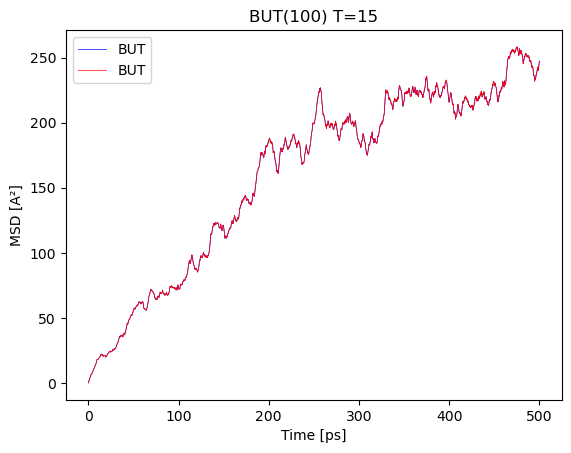

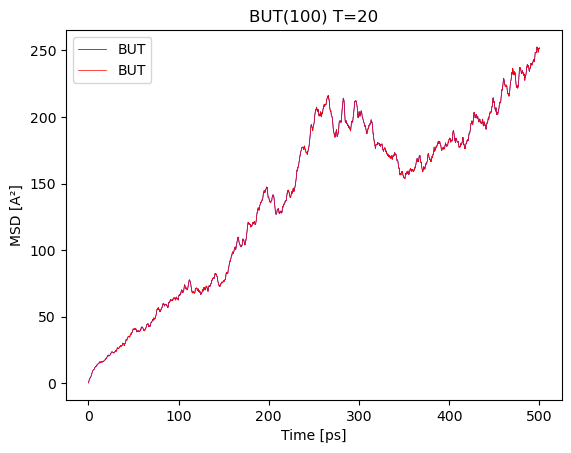

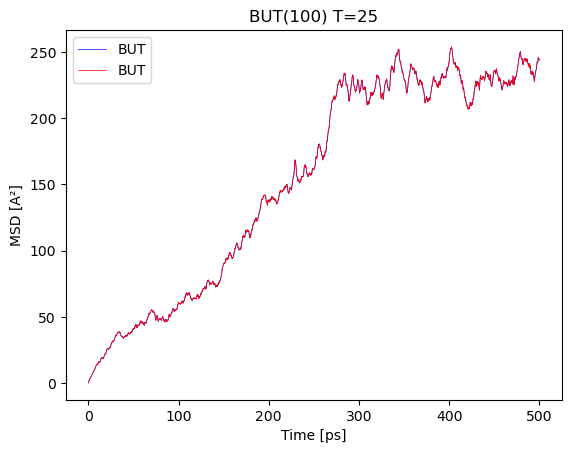

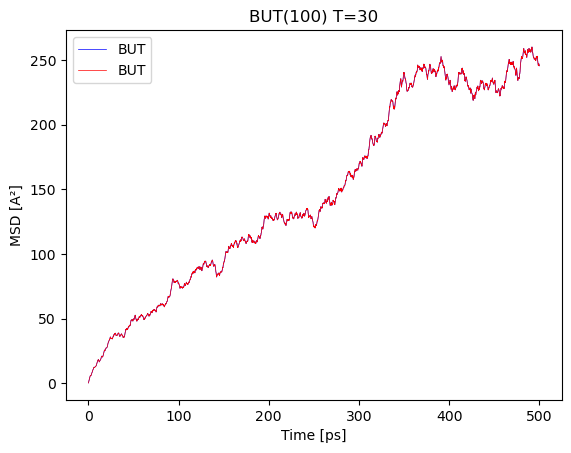

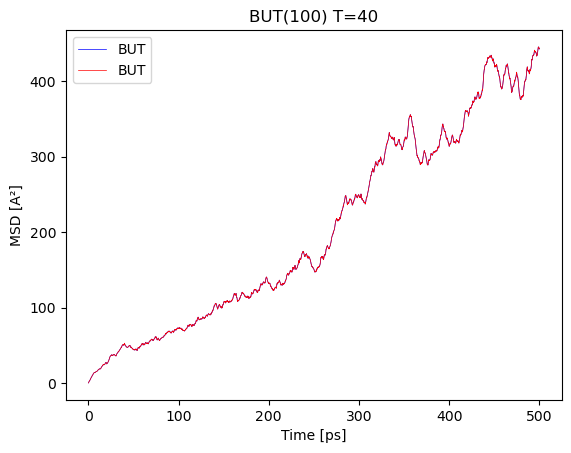

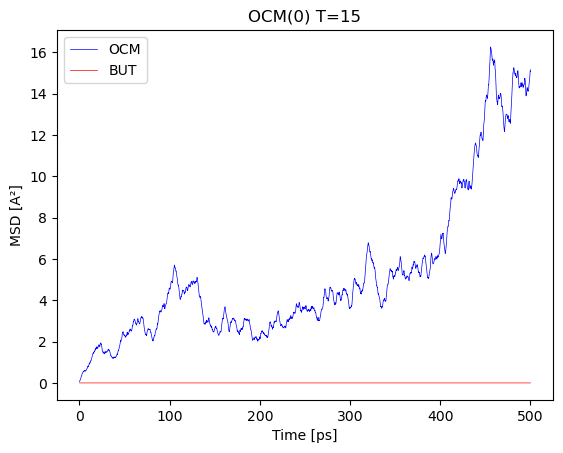

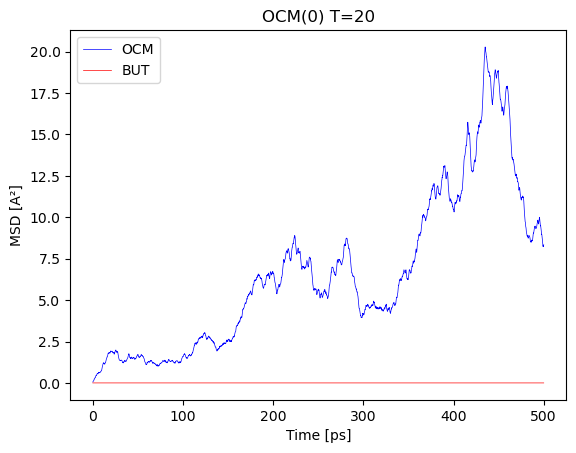

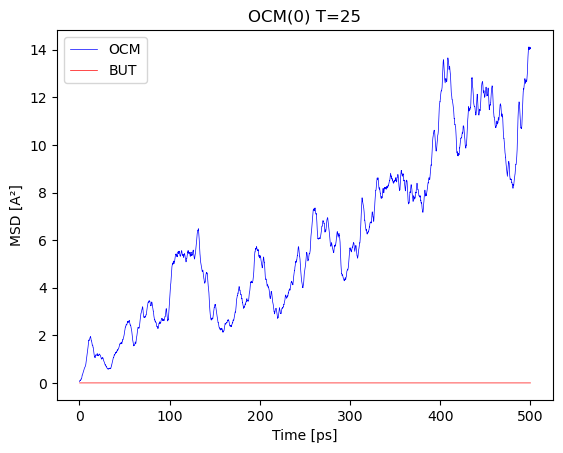

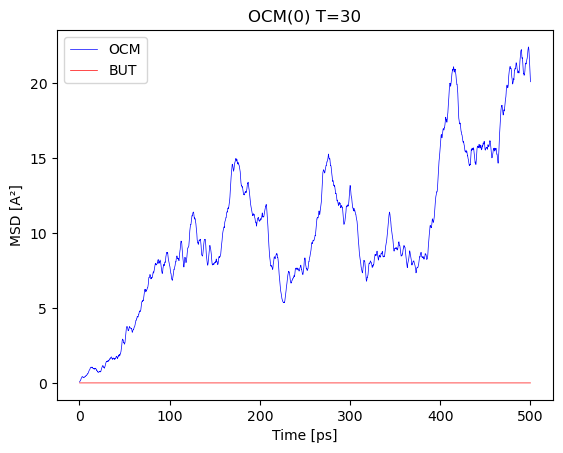

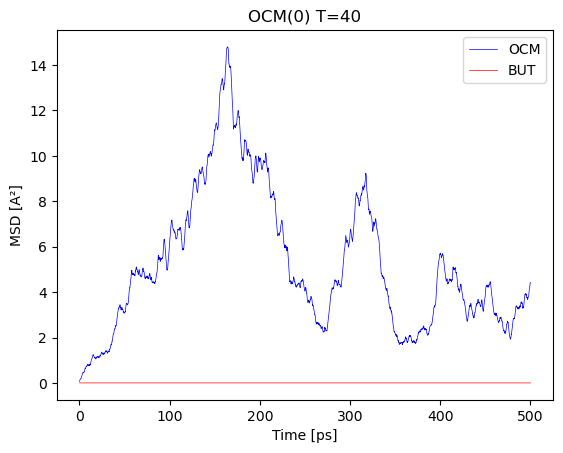

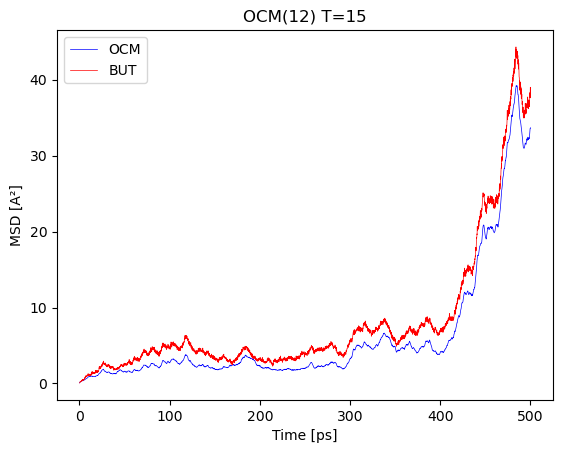

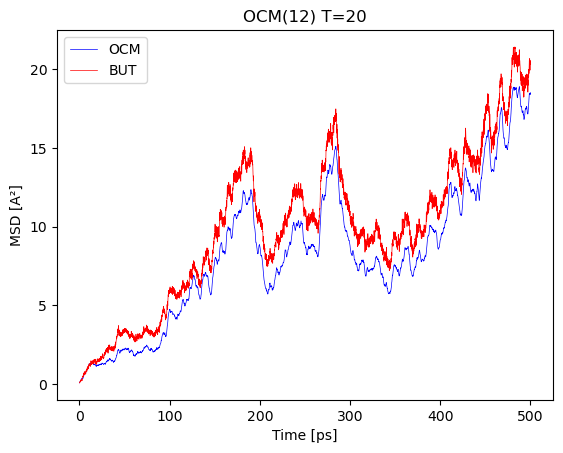

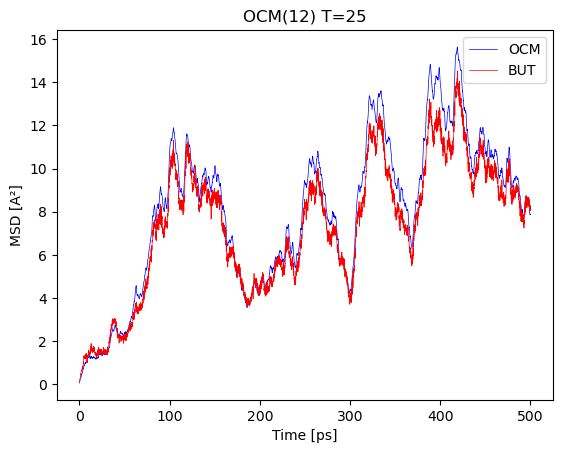

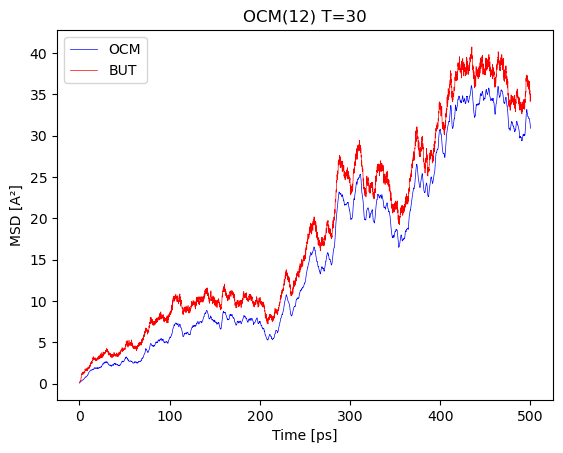

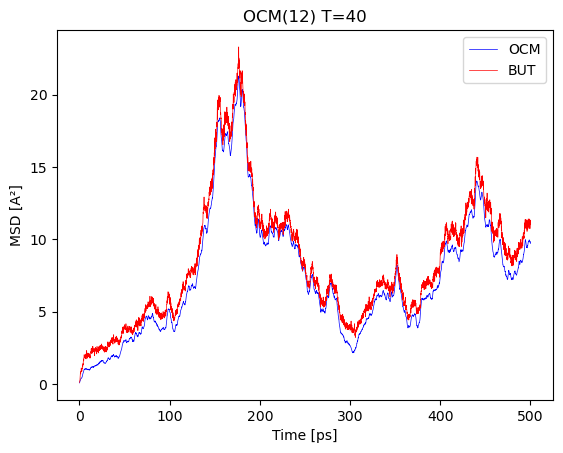

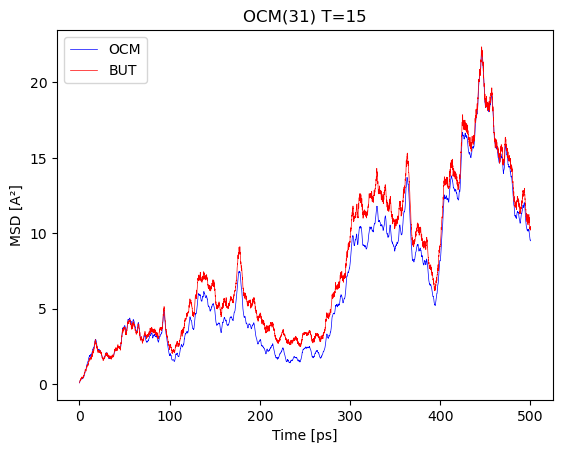

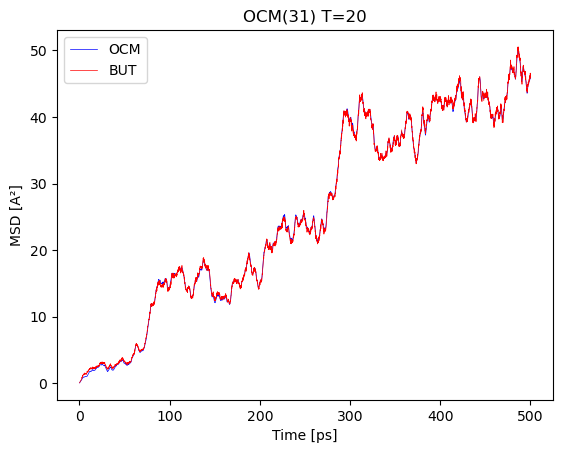

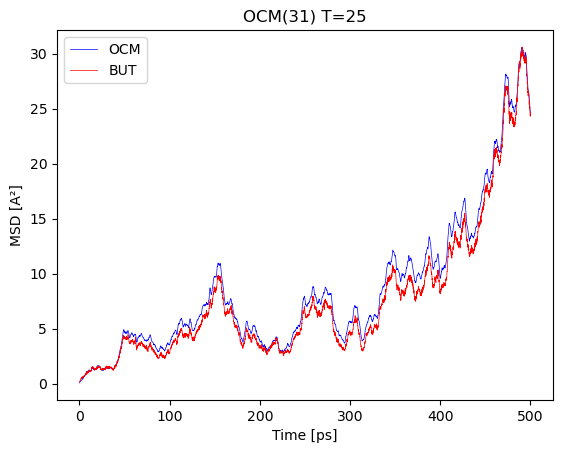

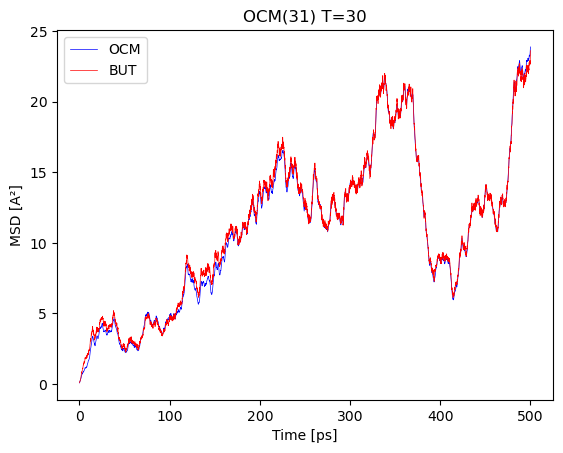

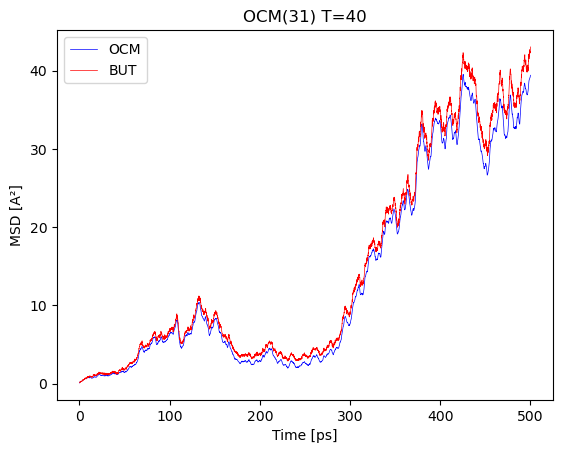

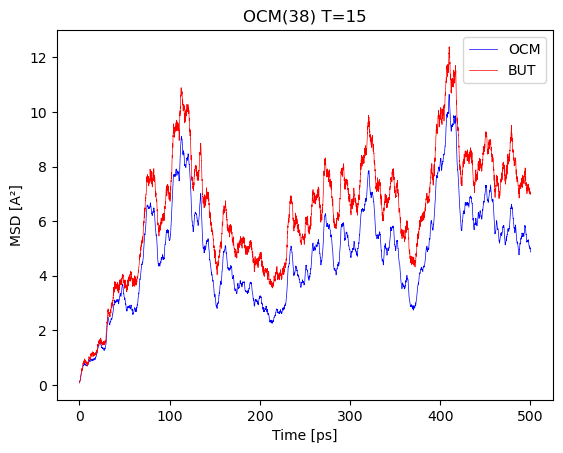

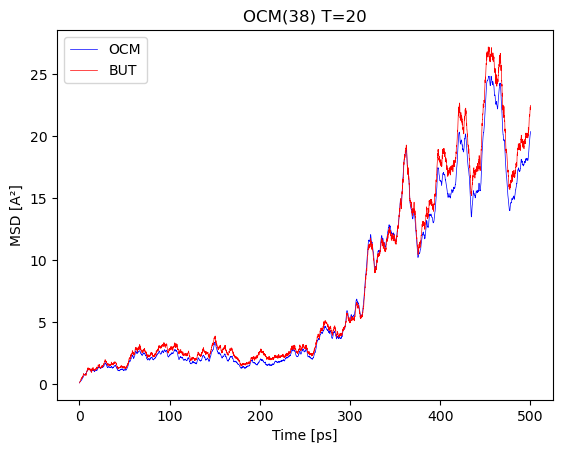

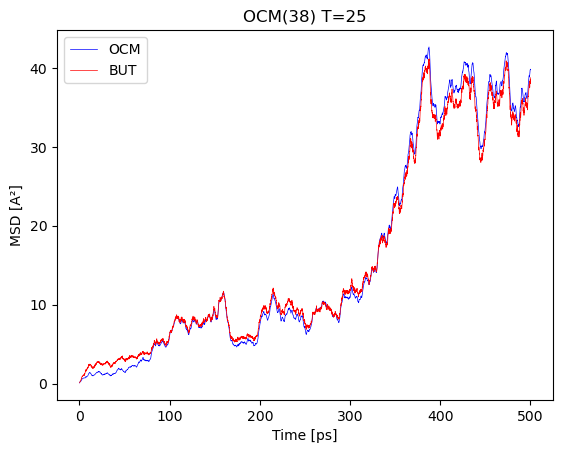

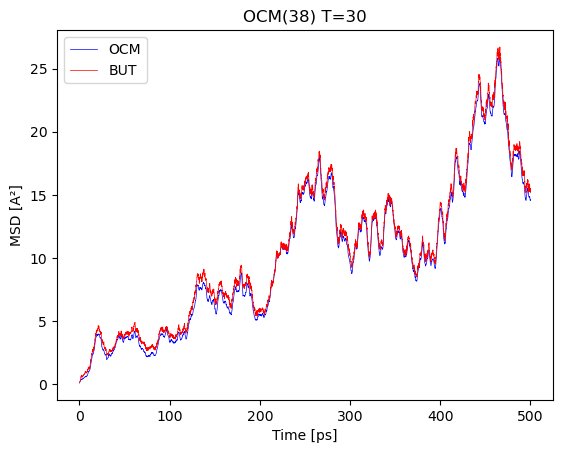

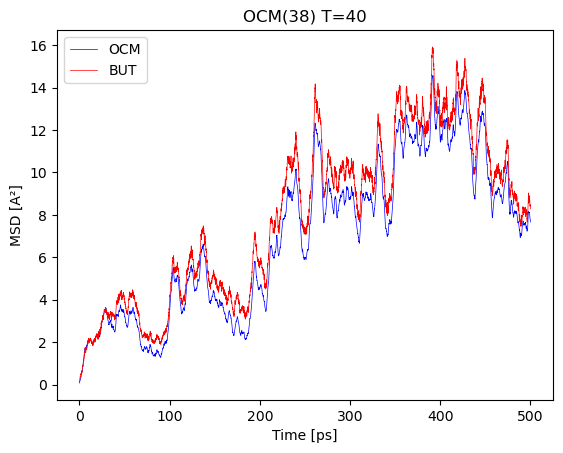

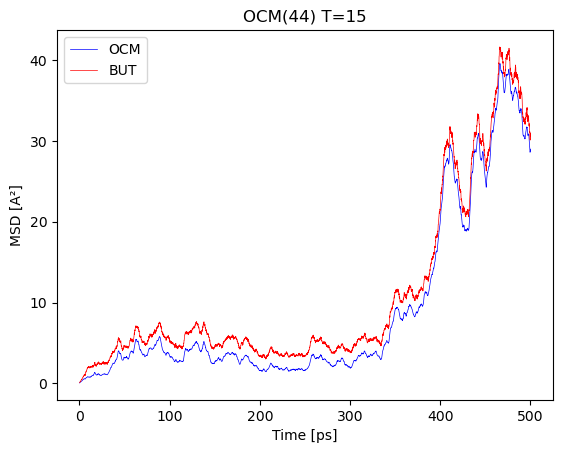

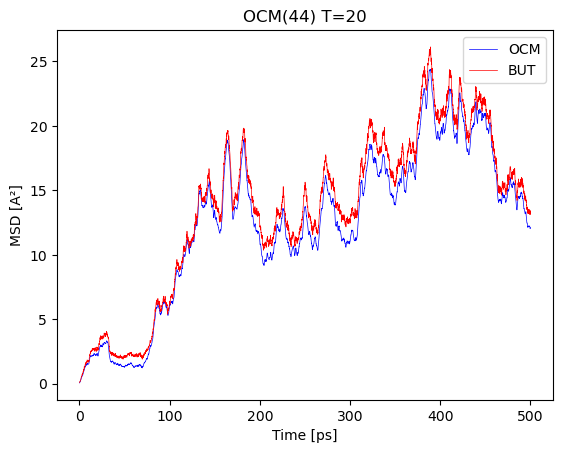

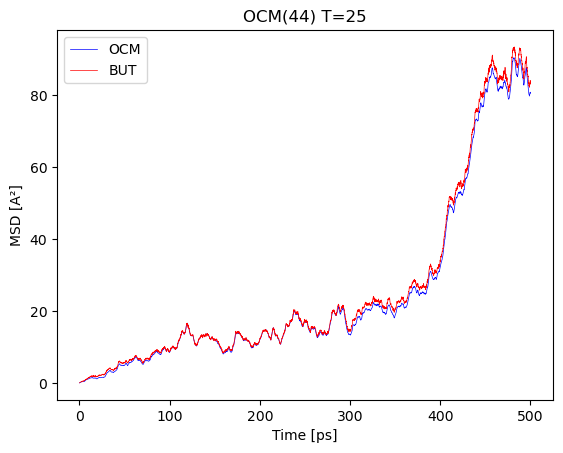

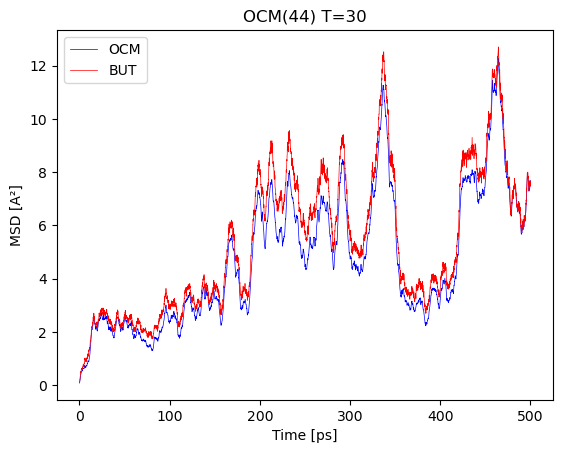

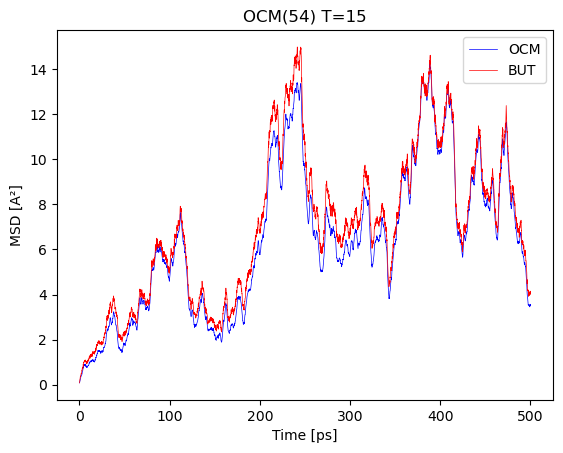

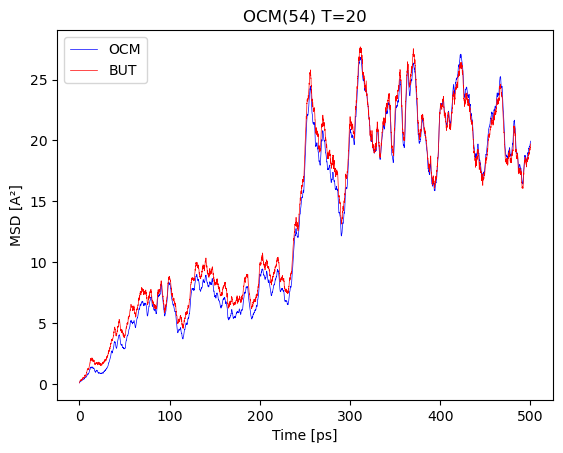

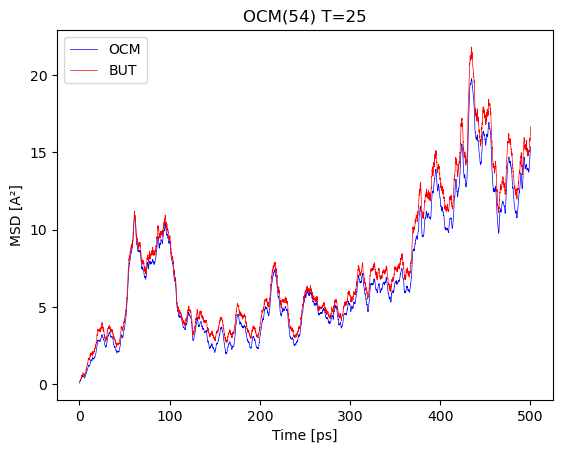

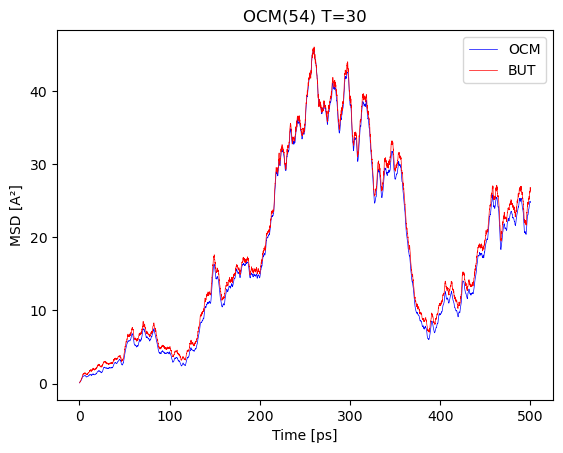

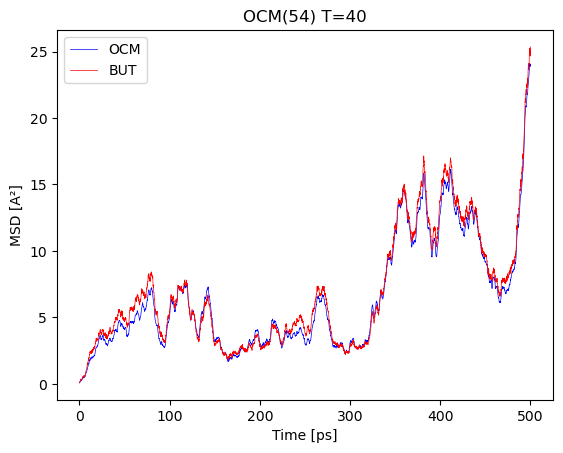

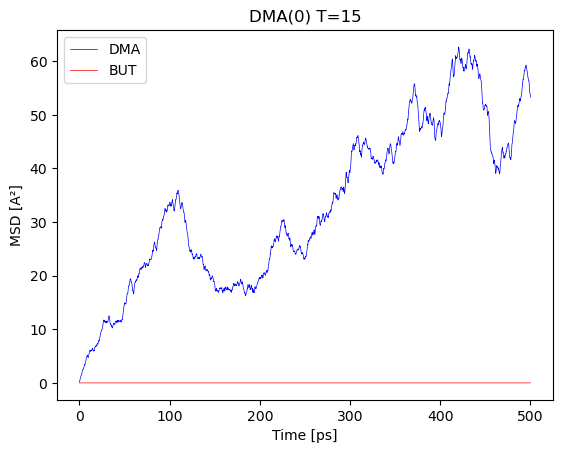

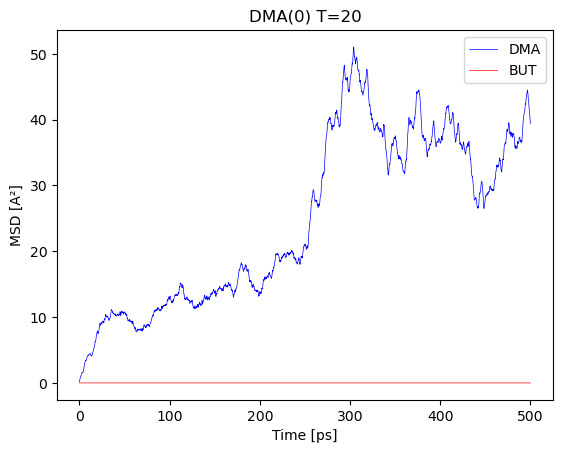

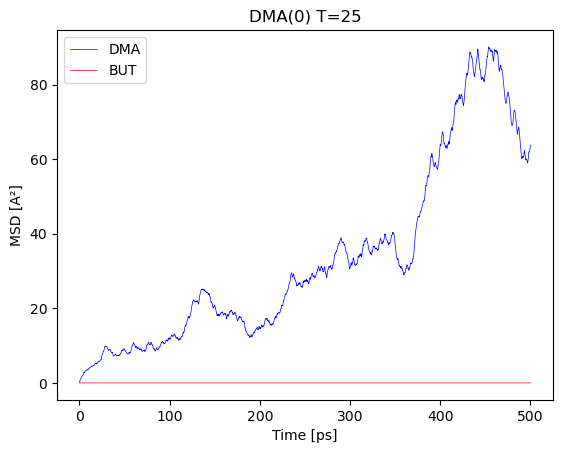

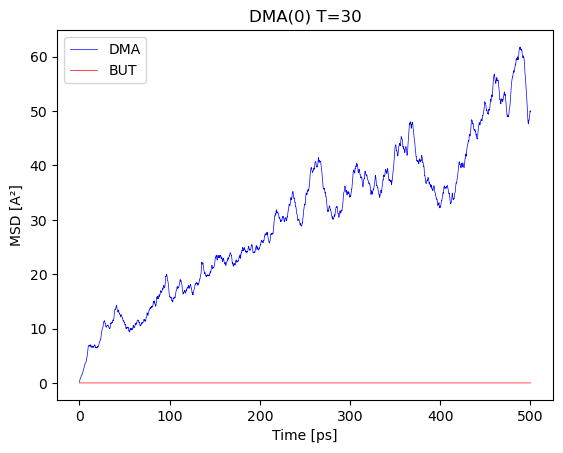

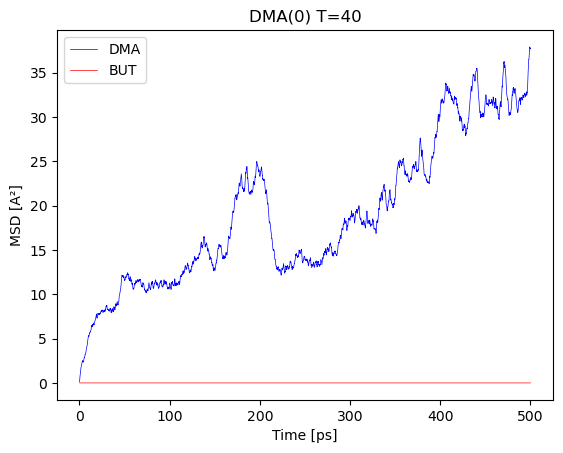

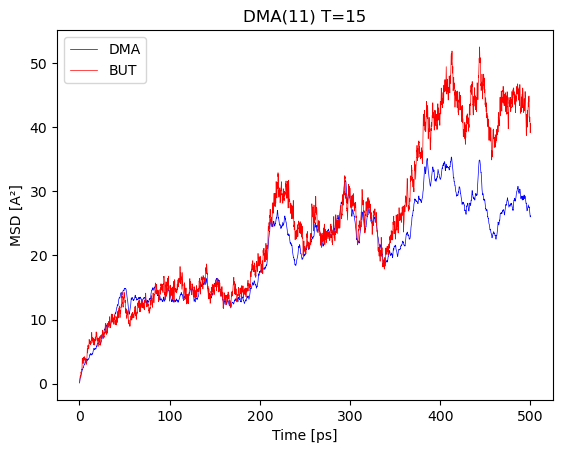

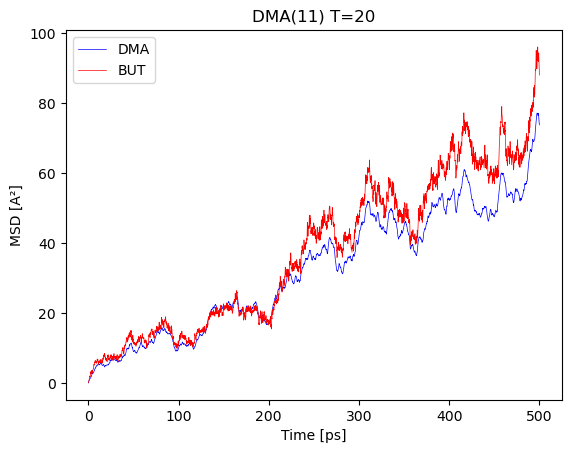

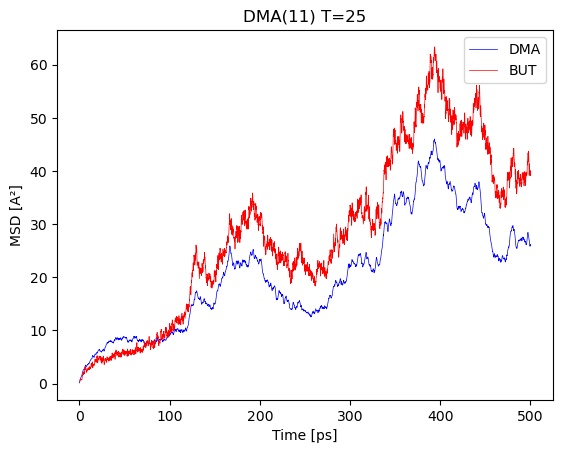

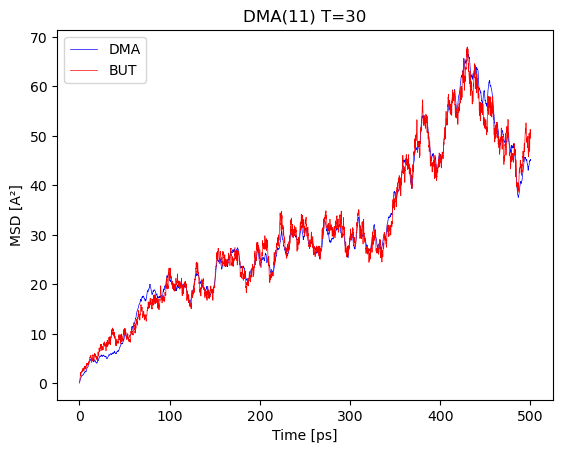

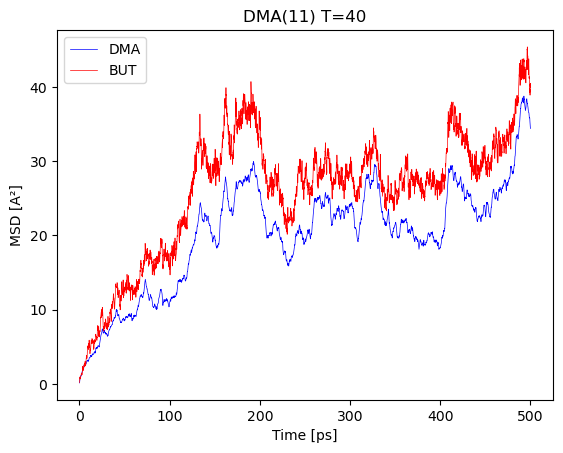

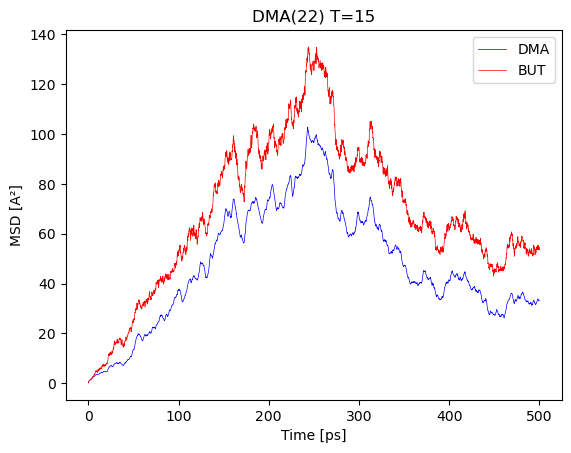

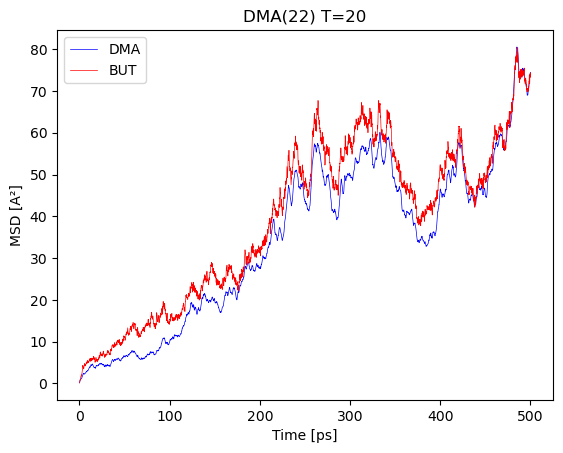

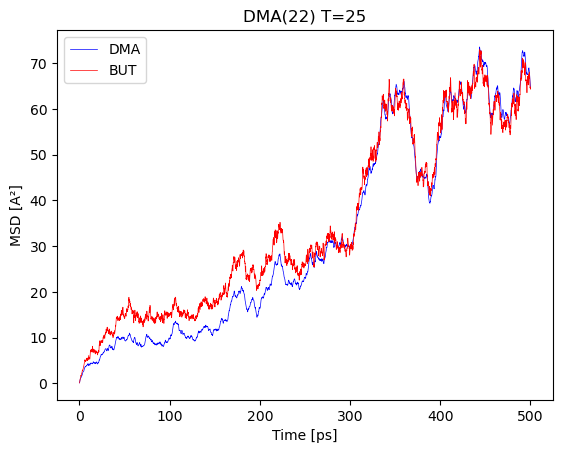

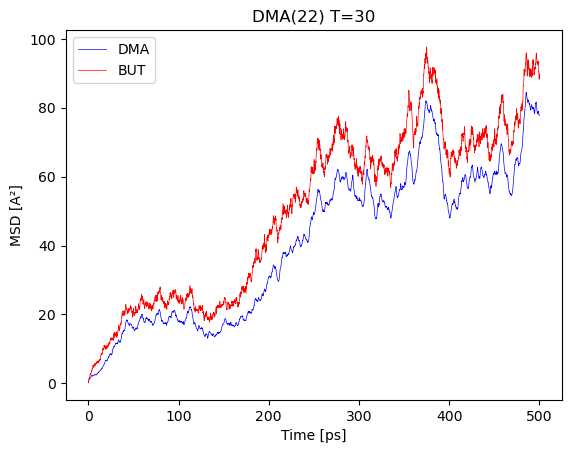

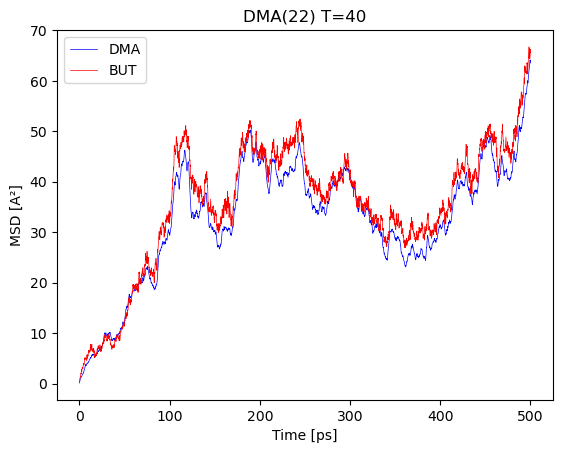

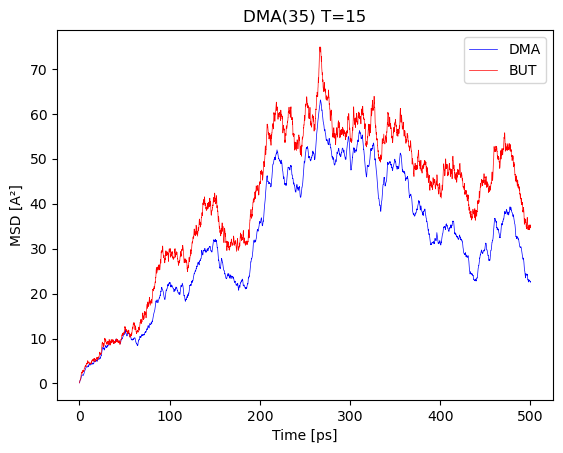

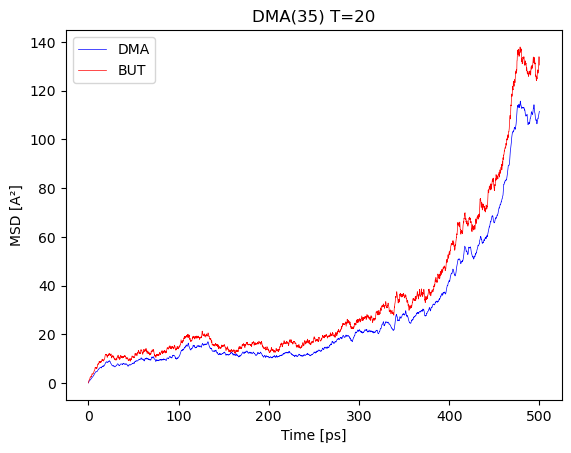

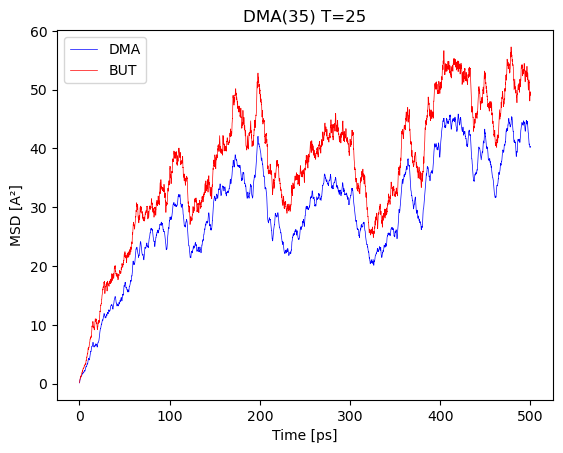

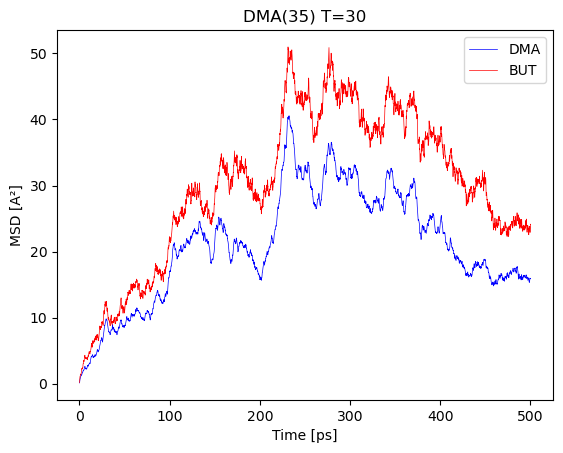

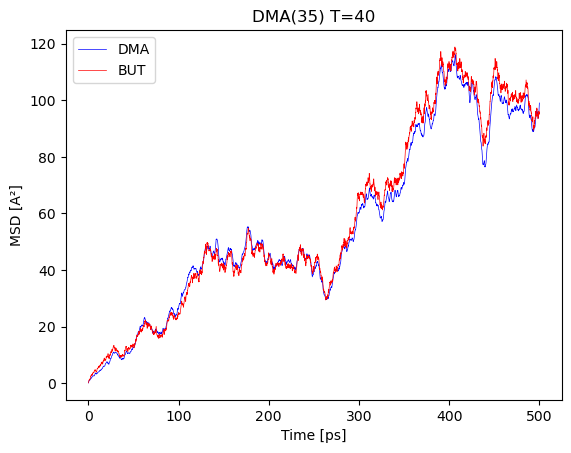

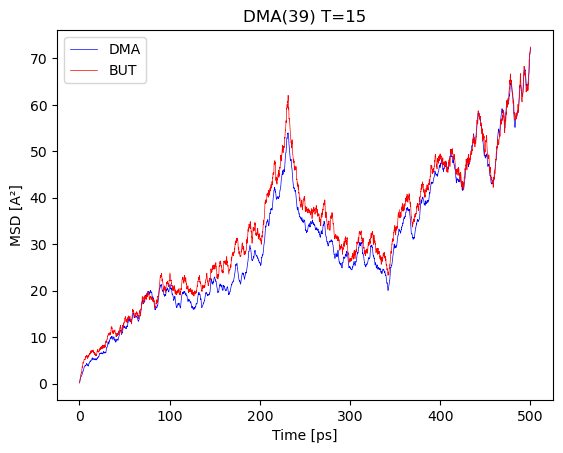

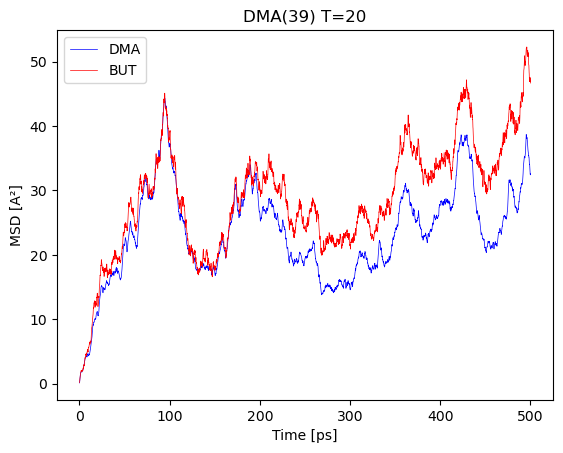

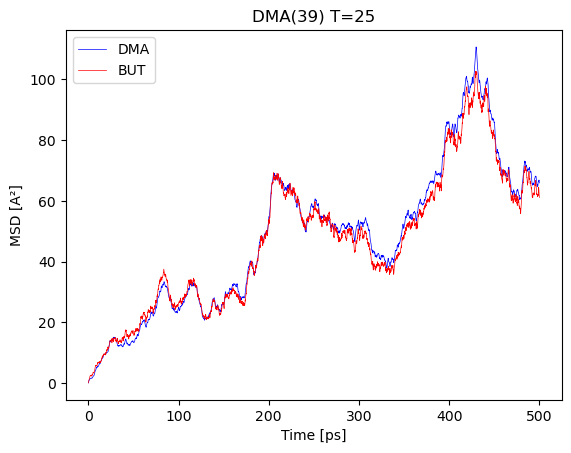

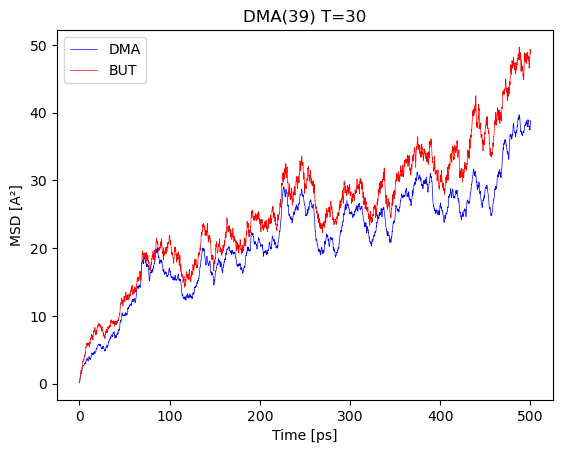

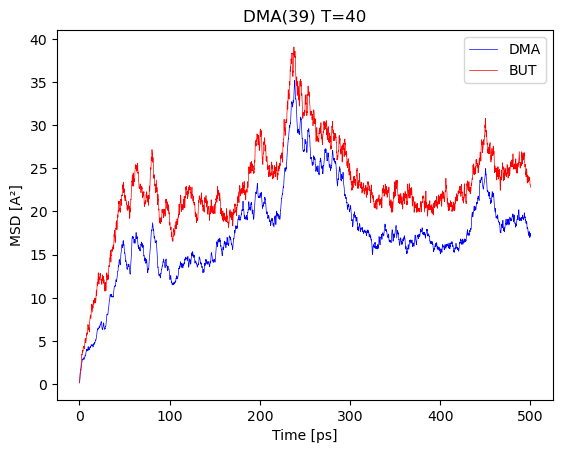

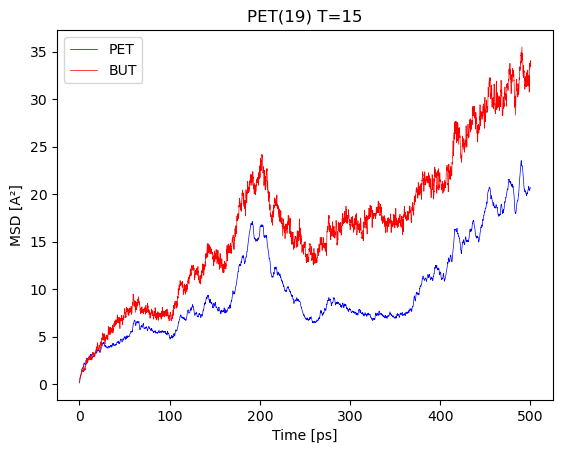

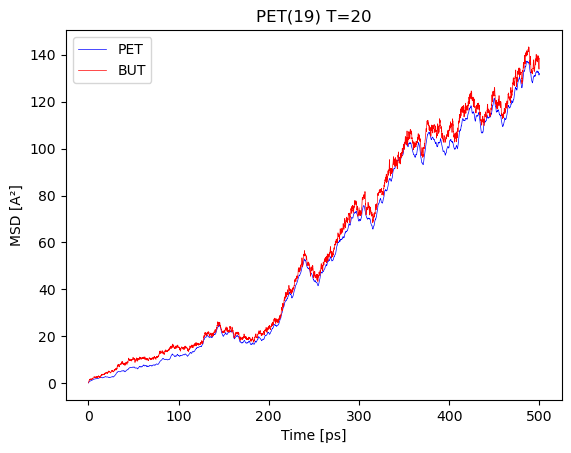

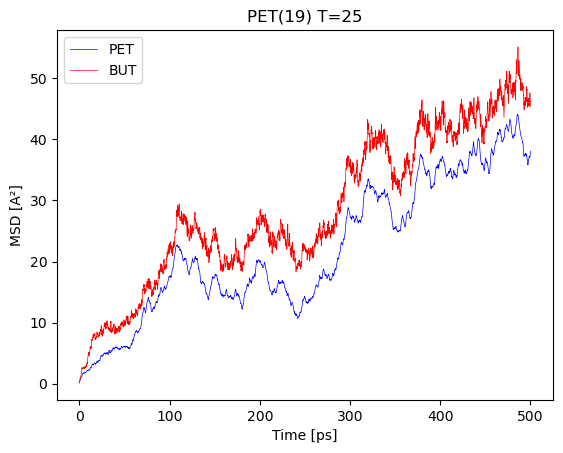

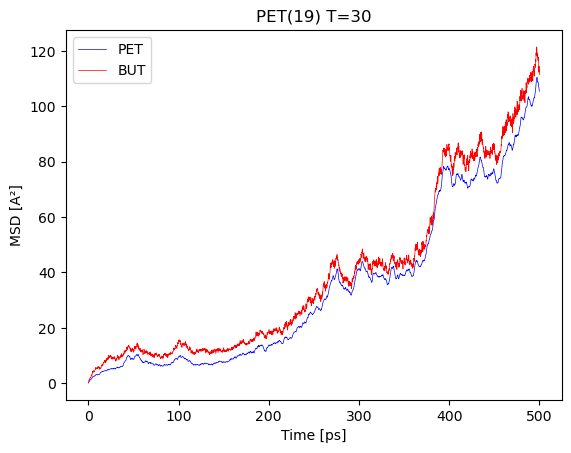

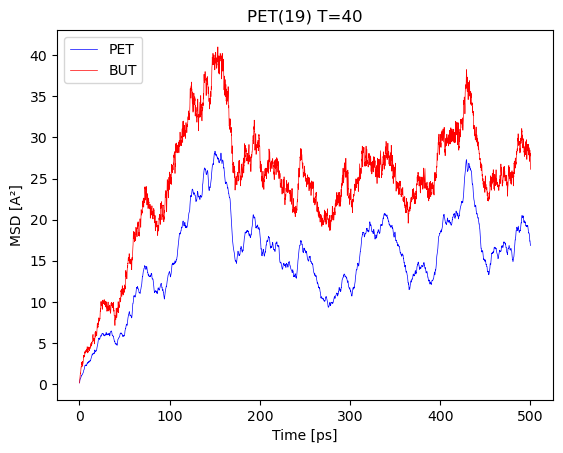

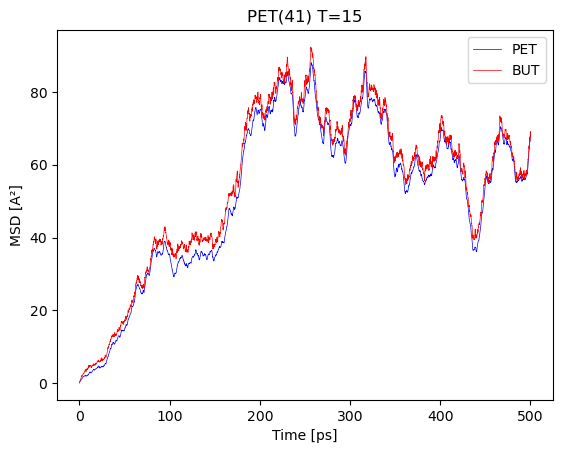

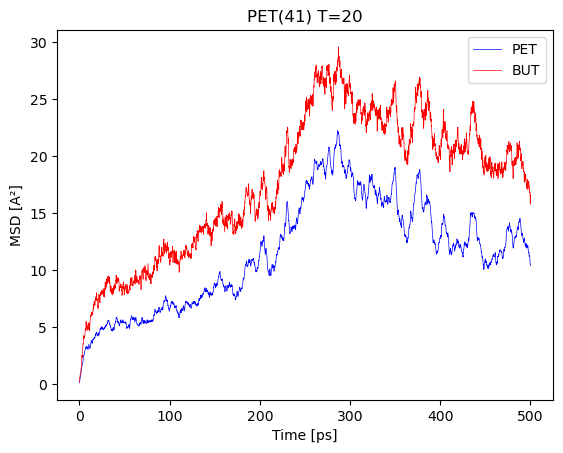

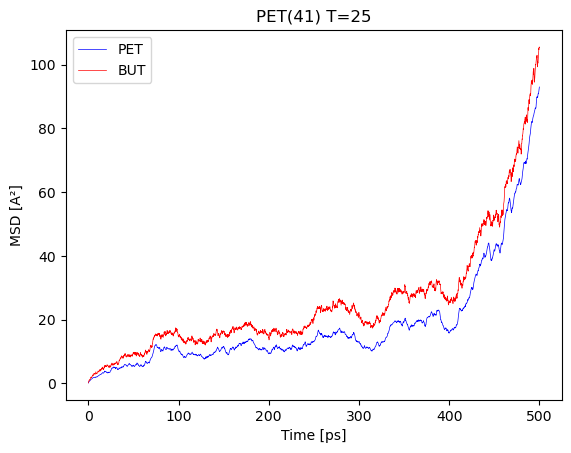

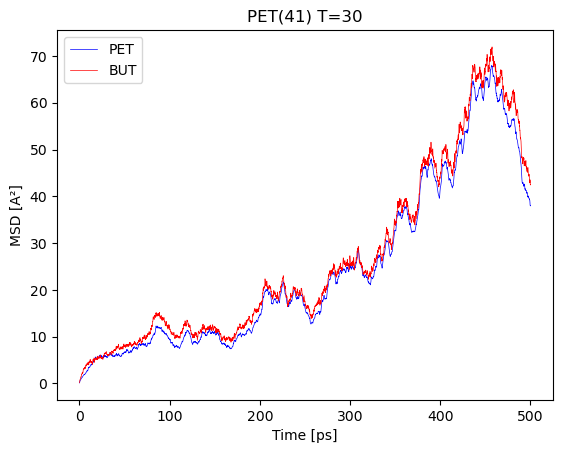

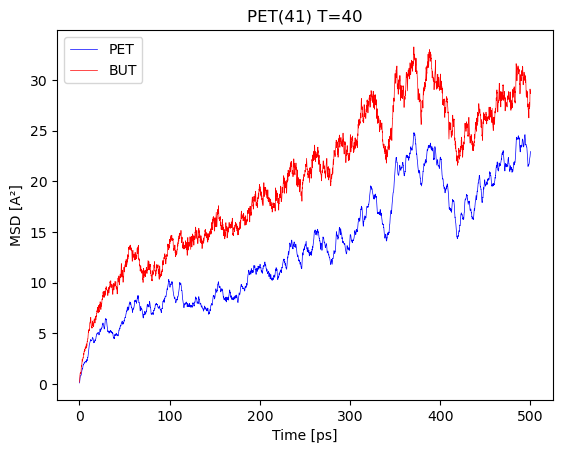

In [62]:
color = 'black'
for mol in MolNames:
    for x in [i[0] for i in simulator.DATAS[mol]]:
        for T in [15, 20, 25, 30, 40]:
            df = DF[(DF['substance'] == mol.value) & (DF['x'] == x) & (DF['T'] == T)]
            if len(df) == 0:
                continue
            fig, ax = plt.subplots()

            ax.plot(
                df['Time'] * 10**12,
                df['MSE_substance'] * 10**16,
                label=mol.value,
                linewidth=0.5,
                c='blue',
            )
            ax.plot(
                df['Time'] * 10**12,
                df['MSE_butanol'] * 10**16,
                label='BUT',
                linewidth=0.5,
                c='red',
            )

            ax.set_title(f'{mol.value}({x}) {T=}')
            ax.set_xlabel('Time [ps]')
            ax.set_ylabel('MSD [A²]')
            ax.legend()
            plt.show()


In [56]:
DF_D = extract_D(DF)
DF_D

,substance,x,T,D_substance,D_butanol
0,BUT,100,15,0.666173,0.666173
1,BUT,100,20,0.624319,0.624319
2,BUT,100,25,0.752900,0.752900
3,BUT,100,30,0.729460,0.729460
4,BUT,100,40,1.278024,1.278024
...,...,...,...,...,...
64,PET,41,15,0.145825,0.143770
65,PET,41,20,0.032527,0.048084
66,PET,41,25,0.131071,0.158539
67,PET,41,30,0.167272,0.174952


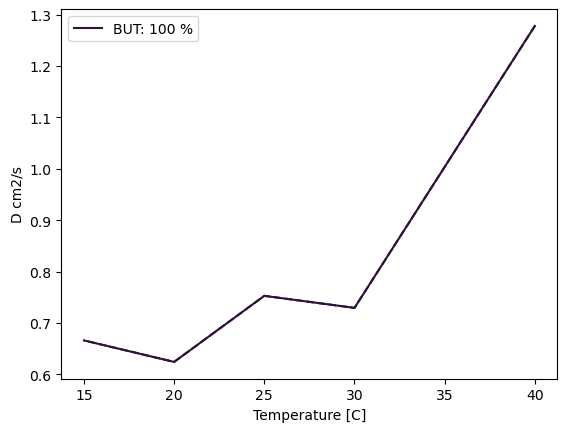

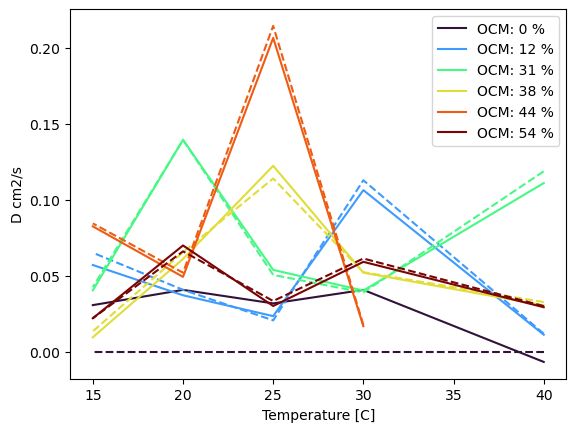

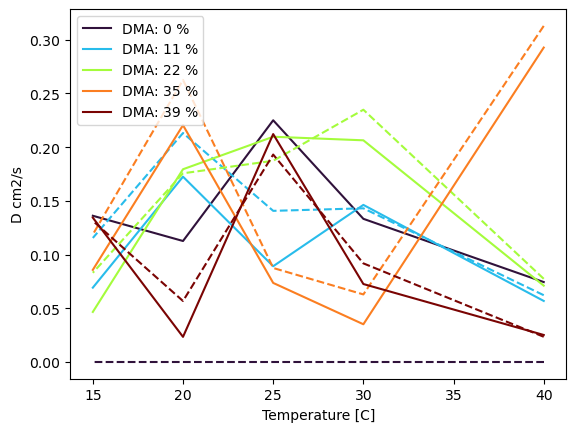

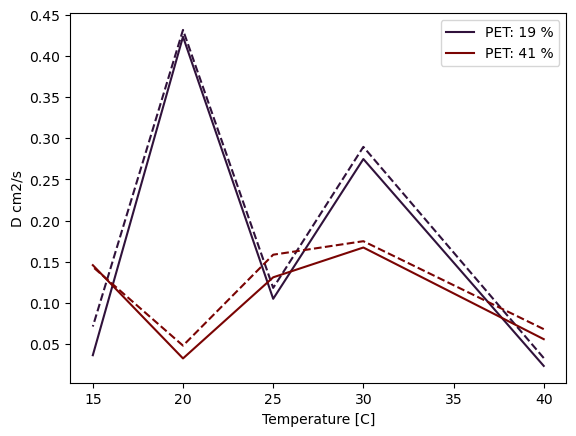

In [55]:
for substance in MolNames:
    substance = substance.value
    df_sub = DF_D[DF_D['substance'] == substance]
    colors_list = mcp.gen_color(
        cmap="turbo",
        n=len(df_sub['x'].unique()),
    )
    fig, ax = plt.subplots(num="DT")
    i = 0
    for [x], df in df_sub.groupby(by=['x']):
        data_x = df.sort_values(by=['T'], ascending=False)
        ax.plot(
            data_x['T'],
            data_x['D_substance'],
            label=f"{substance}: {x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['T'],
            data_x['D_butanol'],
            linestyle='dashed',
            c=colors_list[i],
        )
        i+=1
    ax.set_xlabel("Temperature [C]")
    ax.set_ylabel("D cm2/s")
    ax.legend()
    plt.show()